# Project 5 - Retail Analysis with Walmart Data

In [1]:
import pandas as pd
import numpy as np
import zipfile
from scipy.stats import variation
import scipy.stats as stats
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

### Import the Dataset

In [2]:
with zipfile.ZipFile('1577429980_walmart_store_sales.zip','r') as zip_ref:
    zip_ref.extractall('Project 05 - Retail Analysis with Walmart Data')

In [3]:
dateparse = lambda x: pd.datetime.strptime(x,'%d-%m-%Y')
walmart = pd.read_csv('Project 05 - Retail Analysis with Walmart Data/Walmart_Store_sales.csv',parse_dates=['Date'],date_parser=dateparse)
walmart.shape

<ipython-input-3-ac80791f74b5>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda x: pd.datetime.strptime(x,'%d-%m-%Y')


(6435, 8)

In [4]:
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
walmart.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [6]:
walmart.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

## Task 1 - Which store has maximum sales

In [7]:
weekly_sales = pd.DataFrame(walmart.groupby(['Store'])['Weekly_Sales'].max().sort_values(ascending=False)).reset_index()
weekly_sales['Weekly_Sales'] = weekly_sales['Weekly_Sales'].astype(float)
weekly_sales.head()

,Store,Weekly_Sales
0,14,3818686.45
1,20,3766687.43
2,10,3749057.69
3,4,3676388.98
4,13,3595903.20


According to the above table, it would appear that the store 14 has maximum sales at 3818686.45

## Task 2 - Which store has maximum standard deviation i.e., the sales vary a lot. Also, find out the coefficient of mean to standard deviation

In [8]:
weekly_sales = pd.DataFrame(walmart.groupby(['Store'])['Weekly_Sales'].std().sort_values(ascending=False)).reset_index()
weekly_sales['Weekly_Sales'] = round(weekly_sales['Weekly_Sales'].astype(float),2)
weekly_sales.head()

,Store,Weekly_Sales
0,14,317569.95
1,10,302262.06
2,20,275900.56
3,4,266201.44
4,13,265507.00


According to the above table, it would appear that the store 14 has maximum standard deviation of sales at 317569.95

In [9]:
print("Mean = {}\nStandard Deviation = {}\nCoefficient of Variation = {}".format(round(walmart['Weekly_Sales'].mean(),2),round(walmart['Weekly_Sales'].std(),2),round(variation(walmart['Weekly_Sales'])*100,2)))

Mean = 1046964.88
Standard Deviation = 564366.62
Coefficient of Variation = 53.9


The Coefficient of Variation was found to be 53.90

## Task 3 - Which stores have good quarterly growth rate in Q3’2012 

In [10]:
walmart['Quarter'] = walmart['Date'].dt.quarter
walmart['Year'] = walmart['Date'].dt.year
walmart_sort = walmart.sort_values(by=['Store','Date'])
walmart['Growth'] = pd.DataFrame.pct_change(walmart_sort['Weekly_Sales'])
walmart_growth = pd.DataFrame(walmart.groupby(['Store','Quarter','Year'])['Weekly_Sales','Growth'].sum().sort_values(ascending=True,by='Growth')).reset_index()
qtr_growth_2012 = walmart_growth[walmart_growth['Year']==2012]
qtr_growth_2012_q3 = qtr_growth_2012[qtr_growth_2012['Quarter']==3]
qtr_growth_2012_q3.head()

<ipython-input-10-7e34f7372c4e>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  walmart_growth = pd.DataFrame(walmart.groupby(['Store','Quarter','Year'])['Weekly_Sales','Growth'].sum().sort_values(ascending=True,by='Growth')).reset_index()


,Store,Quarter,Year,Weekly_Sales,Growth
19,7,3,2012,8262787.39,-0.264080
36,16,3,2012,7121541.64,-0.166426
39,6,3,2012,20167312.24,-0.144897
46,27,3,2012,22307711.41,-0.136554
58,15,3,2012,7612081.03,-0.097343


According to the above table, it would appear that store 7 has a good quarterly growth in Q3’2012

## Task 4 - Some holidays have a negative impact on sales. Find out holidays which have higher sales than the mean sales in non-holiday season for all stores together

In [11]:
walmart_holiday = walmart[walmart['Holiday_Flag']==1].reset_index()
walmart_holiday = walmart_holiday[['Store','Date','Weekly_Sales']]
walmart_holiday['Month'] = walmart_holiday['Date'].dt.month
walmart_holiday.head()

,Store,Date,Weekly_Sales,Month
0,1,2010-02-12,1641957.44,2
1,1,2010-09-10,1507460.69,9
2,1,2010-11-26,1955624.11,11
3,1,2010-12-31,1367320.01,12
4,1,2011-02-11,1649614.93,2


In [12]:
walmart_non_holiday = walmart[walmart['Holiday_Flag']==0].reset_index()
walmart_non_holiday = walmart_non_holiday[['Store','Date','Weekly_Sales']]
walmart_non_holiday_mean = round(walmart_non_holiday['Weekly_Sales'].mean(),2)
print("The mean sales in non-holiday season for all stores together was found to be",walmart_non_holiday_mean)

The mean sales in non-holiday season for all stores together was found to be 1041256.38


In [13]:
walmart_sales_gt_mean = walmart_holiday[walmart_holiday['Weekly_Sales']>walmart_non_holiday_mean]
walmart_sales_gt_mean['Date'].value_counts()

2011-11-25    31
2010-11-26    30
2012-09-07    22
2012-02-10    22
2010-02-12    21
2011-09-09    20
2011-02-11    20
2010-09-10    19
2011-12-30    19
2010-12-31    16
Name: Date, dtype: int64

In [14]:
Event = {2:'Super Bowl',9:'Labour Day',11:'Thanksgiving',12:'Christmas'}
walmart_sales_gt_mean = walmart_sales_gt_mean.replace({'Month': Event})
walmart_sales_gt_mean.rename(columns={'Month':'Event'}, inplace = True)
walmart_sales_eventwise = pd.DataFrame(walmart_sales_gt_mean.groupby(['Event','Store'])['Weekly_Sales'].sum().reset_index())
walmart_sales_eventwise.head()

,Event,Store,Weekly_Sales
0,Christmas,1,2864782.73
1,Christmas,2,3624661.07
2,Christmas,4,3801974.60
3,Christmas,6,3062130.54
4,Christmas,10,3637988.51


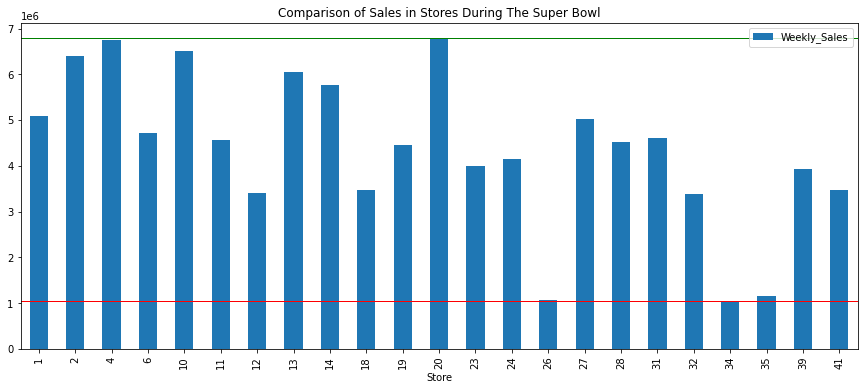

In [15]:
superbowl = walmart_sales_eventwise[walmart_sales_eventwise['Event']=='Super Bowl'].set_index(['Store'])
superbowl.plot(kind='bar',figsize=(15,6),title='Comparison of Sales in Stores During The Super Bowl')
plt.axhline(y=superbowl['Weekly_Sales'].max(),linewidth=1, color='green')
plt.axhline(y=superbowl['Weekly_Sales'].min(),linewidth=1, color='red')
plt.show()

From the figure above, store 20 seems to have maximum sales during The Super Bowl, while store 34 seems to have minimum sales.

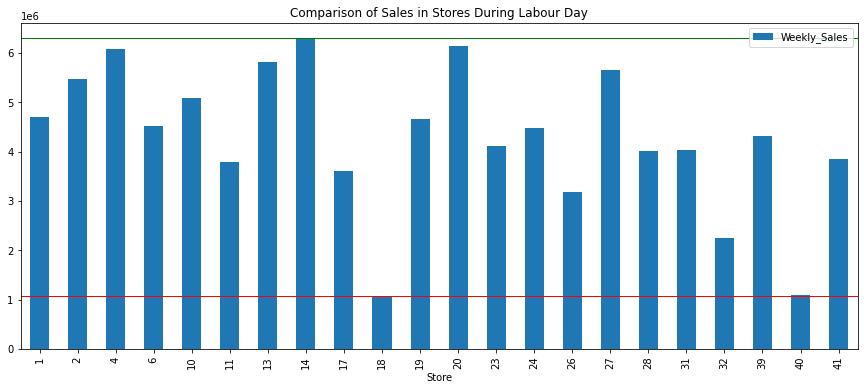

In [16]:
labourday = walmart_sales_eventwise[walmart_sales_eventwise['Event']=='Labour Day'].set_index(['Store'])
labourday.plot(kind='bar',figsize=(15,6),title='Comparison of Sales in Stores During Labour Day')
plt.axhline(y=labourday['Weekly_Sales'].max(),linewidth=1, color='green')
plt.axhline(y=labourday['Weekly_Sales'].min(),linewidth=1, color='red')
plt.show()

From the figure above, store 14 seems to have maximum sales during Labour Day, while store 18 seems to have minimum sales.

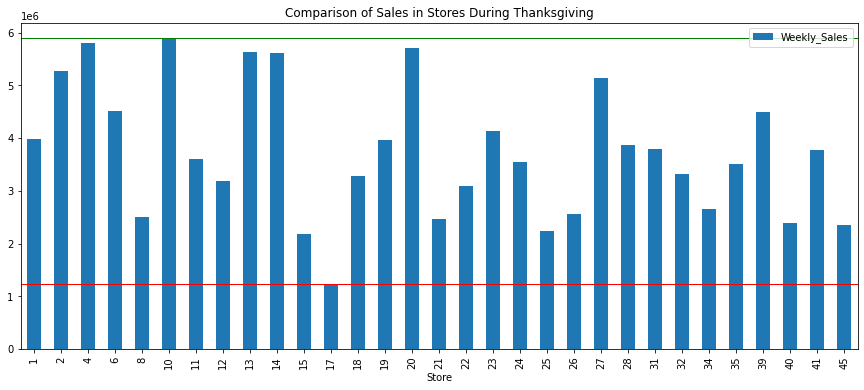

In [17]:
thanksgiving = walmart_sales_eventwise[walmart_sales_eventwise['Event']=='Thanksgiving'].set_index(['Store'])
thanksgiving.plot(kind='bar',figsize=(15,6),title='Comparison of Sales in Stores During Thanksgiving')
plt.axhline(y=thanksgiving['Weekly_Sales'].max(),linewidth=1, color='green')
plt.axhline(y=thanksgiving['Weekly_Sales'].min(),linewidth=1, color='red')
plt.show()

From the figure above, store 10 seems to have maximum sales during Thanksgiving, while store 17 seems to have minimum sales.

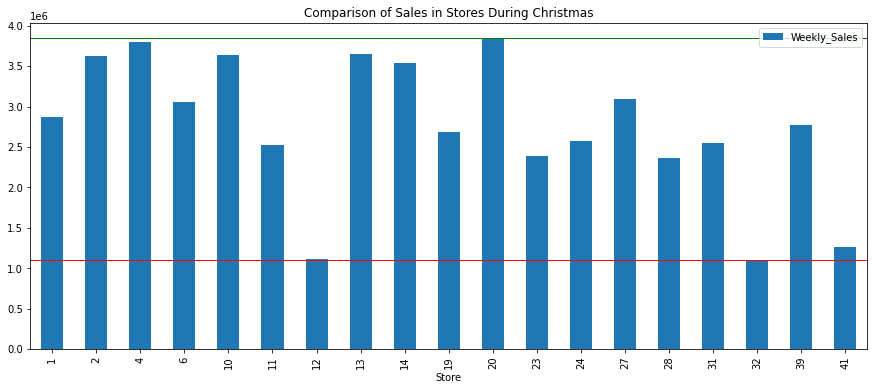

In [18]:
christmas = walmart_sales_eventwise[walmart_sales_eventwise['Event']=='Christmas'].set_index(['Store'])
christmas.plot(kind='bar',figsize=(15,6),title='Comparison of Sales in Stores During Christmas')
plt.axhline(y=christmas['Weekly_Sales'].max(),linewidth=1, color='green')
plt.axhline(y=christmas['Weekly_Sales'].min(),linewidth=1, color='red')
plt.show()

From the figure above, store 20 seems to have maximum sales during Christmas, while store 32 seems to have minimum sales.

## Task 5 - Provide a monthly and semester view of sales in units and give insights

c:\users\jude\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


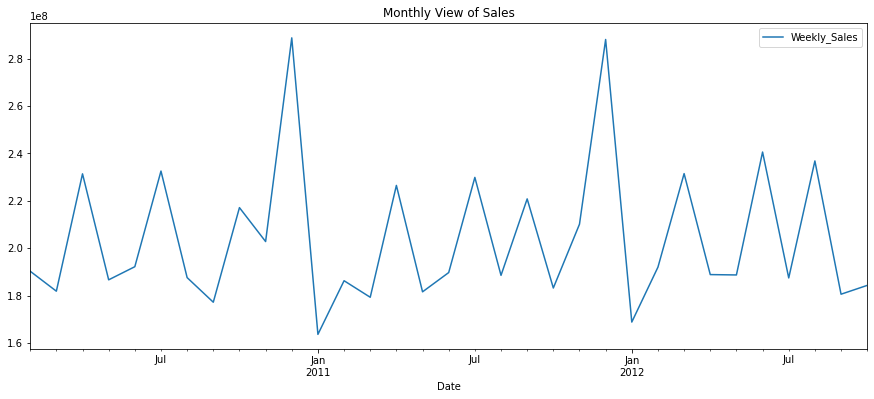

In [19]:
walmart_sales=walmart[['Date','Weekly_Sales']]
walmart_sales.Date = pd.to_datetime(walmart_sales.Date)
walmart_sales.set_index('Date', inplace=True)
walmart_sales.resample('MS').sum().plot(figsize=(15,6),title='Monthly View of Sales')
plt.show()

From the above graph, it would appear that the sales increased and decreased alternately but irregularly, with peaks in December and valleys in January.

c:\users\jude\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


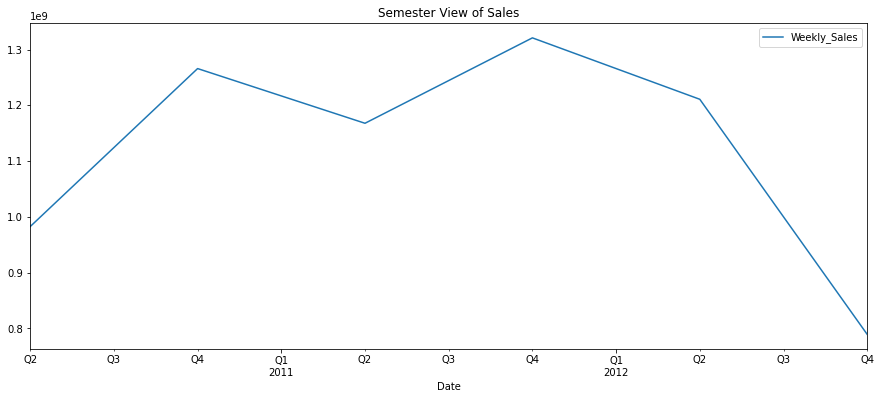

In [20]:
walmart_sales=walmart[['Date','Weekly_Sales']]
walmart_sales.Date = pd.to_datetime(walmart_sales.Date)
walmart_sales.set_index('Date', inplace=True)
walmart_sales.resample('2Q',closed='left').sum().plot(figsize=(15,6),title='Semester View of Sales')#QS
plt.show()

From the above graph, it would appear that the sales increased and decreased alternately, with peaks in July in 2010 & 2011. The sales hit a valley in January 2011 & July 2012.

## Task 6 - Statistical Model For Store 1 – Build prediction models to forecast demand

In [21]:
walmart_first = walmart[walmart['Store']==1].drop(['Quarter','Year','Growth'],axis=1)
walmart_first.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [22]:
walmart_first['Store'].value_counts()

1    143
Name: Store, dtype: int64

### Task 6 Subtask 1 - Linear Regression – Utilize variables like date and restructure dates as 1 for 5 Feb 2010 (starting from the earliest date in order).

In [23]:
label_encoder = preprocessing.LabelEncoder()
walmart_first['Date'] = label_encoder.fit_transform(walmart_first['Date']) 
walmart_first['Date'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142],
      dtype=int64)

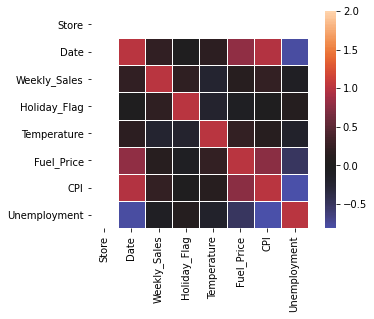

In [24]:
sns.heatmap(walmart_first.corr(),vmax=2,center=0,square=True,linewidths=.5)
plt.show()

### Task 6 Subtask 2 - Hypothesize if CPI, unemployment, and fuel price have any impact on sales. One Way ANOVA
1. Null Hypothesis : CPI, unemployment, and fuel price have no impact on sales
2. Alternate Hypothesis : CPI, unemployment, and fuel price have an impact on sales

<AxesSubplot:>

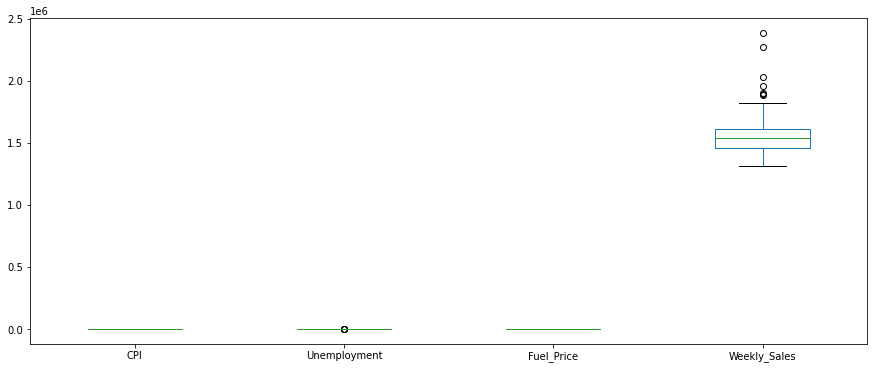

In [25]:
walmart_first.boxplot(column=['CPI','Unemployment','Fuel_Price','Weekly_Sales'],figsize=(15,6),grid=False)

In [26]:
f_value,p_value = stats.f_oneway(walmart_first['CPI'],walmart_first['Unemployment'],walmart_first['Fuel_Price'],walmart_first['Weekly_Sales'])
print("F-value = {}\np-value = {}".format(f_value,p_value))

F-value = 14215.435538539019
p-value = 0.0


In [27]:
walmart_first_melt = pd.melt(walmart_first.reset_index(),id_vars=['index'],value_vars=['CPI','Unemployment','Fuel_Price','Weekly_Sales'])
walmart_first_melt.columns = ['index','treatments','value']
model = ols('value ~ C(treatments)', data=walmart_first_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),2.593962e+14,3.0,14215.435539,0.0
Residual,3.454860e+12,568.0,NaN,NaN


The P-value obtained from ANOVA analysis is significant (P<0.05), hence null hypothesis is rejected. CPI, unemployment, and fuel price have an impact on sales.

Post-hoc comparison

In [28]:
m_comp = pairwise_tukeyhsd(endog=walmart_first_melt['value'],groups=walmart_first_melt['treatments'],alpha=0.05)
print(m_comp)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
   group1       group2      meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------------------
         CPI   Fuel_Price    -212.7772   0.9  -23978.5693    23553.015  False
         CPI Unemployment    -208.3865   0.9  -23974.1786   23557.4057  False
         CPI Weekly_Sales 1555048.4007 0.001 1531282.6085 1578814.1928   True
  Fuel_Price Unemployment       4.3907   0.9  -23761.4014   23770.1829  False
  Fuel_Price Weekly_Sales 1555261.1779 0.001 1531495.3857   1579026.97   True
Unemployment Weekly_Sales 1555256.7871 0.001  1531490.995 1579022.5793   True
-----------------------------------------------------------------------------


<AxesSubplot:xlabel='CPI', ylabel='Weekly_Sales'>

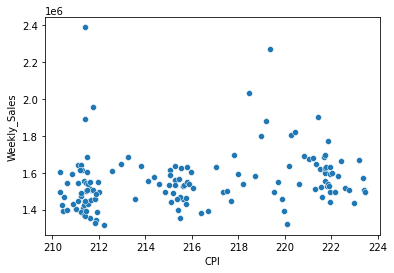

In [29]:
sns.scatterplot(x=walmart_first['CPI'],y=walmart_first['Weekly_Sales'])

<AxesSubplot:xlabel='Fuel_Price', ylabel='Weekly_Sales'>

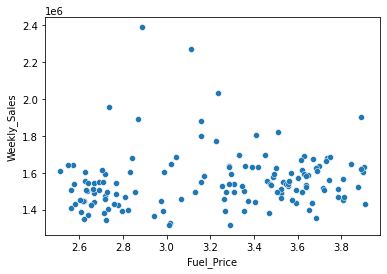

In [30]:
sns.scatterplot(x=walmart_first['Fuel_Price'],y=walmart_first['Weekly_Sales'])

<AxesSubplot:xlabel='Unemployment', ylabel='Weekly_Sales'>

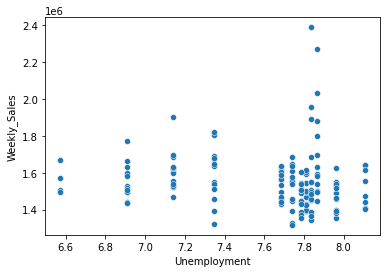

In [31]:
sns.scatterplot(x=walmart_first['Unemployment'],y=walmart_first['Weekly_Sales'])

## Task 7 - Change dates into days by creating new variable. Select the model which gives best accuracy.

### Task 7 Subtask 1 - Post Processing

In [32]:
features=walmart_first.drop(['Store','Weekly_Sales'],axis=1)
label=walmart_first['Weekly_Sales']
features.shape,label.shape

((143, 6), (143,))

In [33]:
x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.3,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 6)
(43, 6)
(100,)
(43,)


#### Model 1 - Linear Regression

In [34]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(x_train,y_train)

LinearRegression(normalize=True)

In [35]:
y_pred=lin_reg.predict(x_test)
acc_lin_reg = round(lin_reg.score(x_train,y_train)*100,2)
acc_lin_reg

10.17

#### Model 2 - KNN Regression

In [36]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(x_train,y_train)

KNeighborsRegressor()

In [37]:
y_pred=knn_reg.predict(x_test)
acc_knn_reg = round(knn_reg.score(x_train,y_train)*100,2)
acc_knn_reg

15.05

#### Model 3 - Random Forest Regression

In [38]:
rf_reg = RandomForestRegressor()
rf_reg.fit(x_train,y_train)

RandomForestRegressor()

In [39]:
y_pred=rf_reg.predict(x_test)
acc_rf_reg = round(rf_reg.score(x_train,y_train)*100,2)
acc_rf_reg

86.76

#### Model Results

In [40]:
models = pd.DataFrame({'Model':['Linear Regression','KNN Regression','Random Forest Regression'],'Score':[acc_lin_reg,acc_knn_reg,acc_rf_reg]})
models.sort_values(by='Score',ascending=False)

,Model,Score
2,Random Forest Regression,86.76
1,KNN Regression,15.05
0,Linear Regression,10.17


In [41]:
print('The best model was found to be {} scoring at {} % on testing data.'.format(models['Model'].loc[models['Score'].idxmax()],max(models['Score'])))

The best model was found to be Random Forest Regression scoring at 86.76 % on testing data.


# ---X---